Context:

In previous notebook (4-activations...ipynb), we utilized PyTorch's autograd(loss.backwards()) for backpropogation. It's bad to use autograd from frameworks without learning it's internals, becuase we won't know why it's performing well or not. We've implemented our own backpropogation for scalars in micrograd but implementing backpropogation instead of frameworks autograd will help to improve debugging neural nets.
As we'll learn the internals of backpropgation it will help more on our undersanding.

# Makemore 5: Becoming a backprop ninja

In [505]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [506]:
# read in all the words
words = open("names.txt").read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [507]:
# build vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [508]:
# build dataset
block_size = 3 # contet length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [509]:
# boilerplate done,to the action

In [510]:
# Utility function to compare manual gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [511]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 64 # number of neurons in hidden layer of MLP
torch_seed = 2147483647

g = torch.Generator().manual_seed(torch_seed) # for reproducability
C = torch.randn(vocab_size, n_embed)

# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # just for understanding, useless because of batch normalization
#Layer 2 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# Batch norm paramters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1 

# Instead of zeros, retaining a samll number, 
# because sometimes initializing with all zeros could mask an incorrect implementation of backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [512]:
batch_size = 32
n = batch_size # shorter variable for conveniance
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [513]:
# Forward pass, "chunkated" into smaller steps that are possible to backward one at a time
emb = C[Xb] # embed chars into vectors
embcat = emb.view(emb.shape[0], -1) # concatenat the vectors

# Linear layer 1
hprebn = embcat @ W1 + b1 # hidden layer pre-activation

# BatchNorm layer
bnmeani = 1 / n*hprebn.sum(0, keepdim=True) # equivalvelnt of torch.mean(0, keepdim=True)

# hprebn - hprebn_mean
bndiff = hprebn - bnmeani

# Variance - average squared deviations from mean
bndiff2 = bndiff**2
bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction dividing by n-1 not n
bnvar_inv = (bnvar + 1e-5)**-0.5 # 1 /square roor -> -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-linearity
h = torch.tanh(hpreact) # hidden layer

# Linear layer 2
logits = h @ W2 + b2 # output layer

# Cross entropy loss (same as F.cross_entropy(logits))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # Subrac max for numerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv,logits,
          norm_logits, logit_maxes, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2,bndiff, hprebn, bnmeani, embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3090, grad_fn=<NegBackward0>)

## Excercis 1: Backpropogating atomic compute graph

### dlogprobs

In [514]:
# dlogprobs
# dlogprobs is logprobs derivate with respect to loss
# how loss is influenced by dlogprobs

In [515]:
logprobs.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [516]:
# Plucking out correct index for character out of (27) for each input in the batch based on Yb(correct index)
# doing a mean of these values and negative
logprobs[range(n), Yb]

tensor([-3.3672, -3.4220, -3.1659, -2.9697, -2.8934, -3.6482, -3.2220, -3.6359,
        -4.4542, -3.2220, -3.7647, -2.4836, -2.3280, -3.2694, -3.5567, -3.1493,
        -2.9697, -2.4225, -3.3109, -3.6932, -2.9209, -3.5075, -3.9461, -3.8828,
        -2.9299, -3.8427, -3.6727, -3.9209, -3.1910, -3.3237, -3.0707, -2.7296],
       grad_fn=<IndexBackward0>)

In [517]:
# loss = -(a + b + c)/3
# We've 32 characters so which is batch
# loss = -(a + b + ....)/32
# loss = -a/32 + -b/32 +......
# dloss/da = -1/32
# -1/n

The derivative of logprobs where indexes are plucked out is -1/n. What about the other indexes which are not plucked out. Since they don't participate in loss. The derivative of those indices will be zero.

In [518]:
dlogprobs = torch.zeros_like(logprobs)
# Setting those indices to 1/n
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0


### probs

In [519]:
# probs
# how probs is affecting logprobs
# logprobs is log of probs

In [520]:
# log_10(x)
# 1 / x * ln(10)
# ln(10) = log_e(10)
# e = 2.71288
# log(x)
# 1 / x

In [521]:
# logprobs = probs.log()
# dlogprobs/respect to probs == 1/probs ln(probs)
# ln(probs) = log_e(probs) where e = 2.71288
# torch.log() - uses natural log
# So dlogprobs/probs = 1 / probs * local_derivative(by chain rule
# dlogprobs/probs = 1 / probs * dlogporbs

Above derivative, i initially assume torch.log() is base 10 and concluded the derivative of torch.log(x) as 1 / x ln (10).
After reading [torch.log](https://pytorch.org/docs/stable/generated/torch.log.html#torch.log) the implementation itself is natural log. Derivate of log(x) will simply be 1/x

In [522]:
probs.shape

torch.Size([32, 27])

In [523]:
dprobs = 1 / probs * dlogprobs

In [524]:
dprobs.shape

torch.Size([32, 27])

In [525]:
cmp('dprobs', dprobs, probs)

dprobs          | exact: True  | approximate: True  | maxdiff: 0.0


### counts_sum_inv

In [526]:
# how probs is affected by counts_sum_inv
# probs = counts * counts_sum_inv
# dprobs / counts_sum_inv = counts * local_gradient

In [527]:
dcounts_sum_inv = counts * dprobs

In [528]:
counts.shape, counts_sum_inv.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

If we look at the shapes, in forward pass implict tensor broadcasting is done by PyTorch to perform matrix multiplication.

In [529]:
counts_sum_inv.shape, dcounts_sum_inv.shape

(torch.Size([32, 1]), torch.Size([32, 27]))

In [530]:
counts_sum_inv.grad.shape

torch.Size([32, 1])

In [531]:
# Doing a sum at dim 1 to match shape to accomodate tensor broadcasting
dcounts_sum_inv = dcounts_sum_inv.sum(1, keepdims=True)
dcounts_sum_inv.shape

torch.Size([32, 1])

In [532]:
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0


### counts_sum

In [533]:
# counts_sum with respect to counts_sum_inv
# dcounts_sum_inv / dcounts_sum = ??
# counts_sum_inv = counts_sum**-1
# derivative of x**-1 -> -1/x**2
# dcounts_sum_inv / dcounts_sum = -1 / counts_sum ** 2 * dcounts_sum_inv

In [534]:
counts_sum.shape, counts_sum_inv.shape

(torch.Size([32, 1]), torch.Size([32, 1]))

In [535]:
dcounts_sum = (-1.0/counts_sum**2) * dcounts_sum_inv
dcounts_sum_inv.shape

torch.Size([32, 1])

Shapes hold good.

In [536]:
cmp('counts_sum', dcounts_sum, counts_sum)

counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0


### counts

In [537]:
# dcounts
# dcounts has two gradients as it influences probs and counts_sum
# we'll need dprobs/dcounts and dcounts_sum/dcounts
# dprobs/dcounts It's multiplication
# dprobs/dcounts = counts_sum_inv * local_gradient

In [538]:
dcounts = counts_sum_inv * dprobs

In [539]:
dcounts.shape, counts.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [540]:
# dcounts_sum/dcounts
# counts_sum = counts.sum(1, keepdims=True)
# Derivative of addition is 1, so gradients just passes through
# to keep shapes, we'll create ones of counts shape and multiply local gradient with it

In [541]:
counts.shape, counts_sum.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

We've to derive array of gradients from counts_sum.
Addition just routes local gradients.

In [542]:
# local gradient
dcounts_sum.shape

torch.Size([32, 1])

In [543]:
# Ones of counts shape
torch.ones_like(counts).shape

torch.Size([32, 27])

Broadcasting [32, 27] with [32, 1] to create array of gradients.

In [544]:
# += to add previous gradinet dprobs/dcount
dcounts1 = torch.ones_like(counts) * dcounts_sum

In [545]:
dcounts.shape, dcounts1.shape

(torch.Size([32, 27]), torch.Size([32, 27]))

In [546]:
dcounts = dcounts + dcounts1

In [547]:
cmp('dcounts', dcounts, counts)

dcounts         | exact: True  | approximate: True  | maxdiff: 0.0


### norm_logits

In [548]:
# counts = norm_logits.exp()
# derivative of exp() is exp() itself
# dcounts / dnorm_logits = norm_logits.exp() * dcounts

In [549]:
norm_logits.shape

torch.Size([32, 27])

In [550]:
dcounts.shape

torch.Size([32, 27])

In [551]:
dnorm_logits = norm_logits.exp() * dcounts
dnorm_logits.shape

torch.Size([32, 27])

In [552]:
cmp('dnorm_logits', dnorm_logits, norm_logits)

dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0


### logit_maxes

In [553]:
# norm_logits = logits - logit_maxes
# dnorm_logits / dlogit_maxes = logits/dlogit_maxes - dlogit_maxex/dlogit_maxes
# = - 1 * dnorm_logits

In [554]:
logit_maxes.shape,logits.shape, dnorm_logits.shape

(torch.Size([32, 1]), torch.Size([32, 27]), torch.Size([32, 27]))

In [555]:
dlogit_maxes = -1 * dnorm_logits
dlogit_maxes.shape

torch.Size([32, 27])

In [556]:
dlogit_maxes = dlogit_maxes.sum(1, keepdim=True)
dlogit_maxes.shape

torch.Size([32, 1])

In [557]:
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0


### dlogits

In [558]:
# logits has two dreivatives
# dnorm_logits/dlogits and dlogit_maxes / dlogits

In [559]:
# dnorm_logits/dlogits = 1 * dnorm_logits

In [560]:
logits.shape

torch.Size([32, 27])

In [561]:
dlogits = 1.0 * dnorm_logits
dlogits.shape

torch.Size([32, 27])

In [562]:
# dlogit_maxes / dlogits
# torch.max() takes max of the dimension
# logit_maxes = logits.max(1, keepdim=True).values
# 0th dimension has zero gradients and 1th dimension has gradient of 1

In [563]:
logit_maxes.shape

torch.Size([32, 1])

In [564]:
dlogits_logit_maxes = torch.zeros_like(logits)
dlogits_logit_maxes.shape

torch.Size([32, 27])

In [565]:
dlogits_logit_maxes

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
      

In [566]:
dlogits_logit_maxes[range(n), logits.max(1).indices] = 1.0
dlogits_logit_maxes.shape

torch.Size([32, 27])

In [567]:
dlogits_logit_maxes

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0

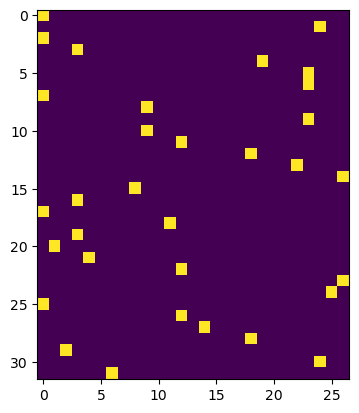

In [568]:
import matplotlib.pyplot as plt
plt.imshow(dlogits_logit_maxes)

In [569]:
dlogits_logit_maxes.shape, dlogit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [570]:
# Tensor broadcasting makse sure that dlogit_maxes values are forwarded only
# on the bits turned on in dlogits_logit_maxes

In [571]:
dlogits_logit_maxes = dlogits_logit_maxes * dlogit_maxes 

In [572]:
dlogits += dlogits_logit_maxes

In [573]:
cmp('dlogits', dlogits, logits)

dlogits         | exact: True  | approximate: True  | maxdiff: 0.0


### dh, dW2, db2

In [574]:
# how h inflluences logits
# local gradient --> dlogits
# logits = h @ W2 + b2

In [575]:
W2.shape, b2.shape, h.shape, logits.shape

(torch.Size([64, 27]),
 torch.Size([27]),
 torch.Size([32, 64]),
 torch.Size([32, 27]))

In [576]:
W2

tensor([[-0.0143, -0.0895, -0.0872,  ...,  0.0151, -0.0417,  0.0593],
        [-0.0297,  0.0812, -0.0663,  ..., -0.0527,  0.1308,  0.2315],
        [ 0.0256,  0.0271,  0.2262,  ...,  0.1242,  0.0248, -0.0531],
        ...,
        [-0.1393,  0.1201, -0.1010,  ..., -0.0118, -0.0138,  0.0103],
        [-0.1787, -0.1160,  0.1549,  ..., -0.0052, -0.1179, -0.1299],
        [-0.0749, -0.0890, -0.1501,  ..., -0.0905, -0.1335,  0.0851]],
       requires_grad=True)

![Alt dh1](images/dh1.jpeg)
![Alt dh2](images/dh2.jpeg)
![Alt dh3](images/dh3.jpeg)

In [577]:
# Looking at the shapes again
W2.shape, b2.shape, h.shape, logits.shape

(torch.Size([64, 27]),
 torch.Size([27]),
 torch.Size([32, 64]),
 torch.Size([32, 27]))

In [578]:
# We know local gradient is dlogits-> [32, 27]
# shape of h which is shape of dh -> [32, 64]
# To get this shape, we've to transpose W2 [64, 27] -> [27, 64]
# Multiplying these which is dlogits @ W2T we arrive at the derived formula above
dh = dlogits @ W2.T
# Similarly
dW2 = h.T @ dlogits
# db2 -> sum of dlogits
# b2 shape -> [27]
# dlogits shape -> [32, 27]
# sum at 0 axis will give desired shape which is deerivate as well
db2 = dlogits.sum(0)

In [579]:
dW2.shape, W2.shape

(torch.Size([64, 27]), torch.Size([64, 27]))

In [580]:
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)

h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0


### dhpreact

In [581]:
# dhpreact == ?
# localgradient = dh
# h = torch.tanh(hpreact)
# dh/dhpreact = 1 - h**2 * dh

![Alt derivativeoftanh](http://ronny.rest/media/blog/2017/2017_08_16_tanh/tanh_and_derivative_formulas.jpg)

In [582]:
# derivative of tanh is 1 - output**2
# here output is h

In [583]:
hpreact.shape, dh.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [584]:
dhpreact = (1 - h**2) * dh

In [585]:
cmp("dhpreact", dhpreact, hpreact)

dhpreact        | exact: True  | approximate: True  | maxdiff: 0.0


### dbngain

In [586]:
# how bngain impacts hpreact
# localgradient -> dhpreact
# dhpreact/dbngain = bnraw * dhpreact

In [587]:
# checking out shapes
bngain.shape, dhpreact.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [588]:
dbngain = bnraw * dhpreact
dbngain.shape

torch.Size([32, 64])

In [589]:
dbngain = dbngain.sum(0, keepdim=True)
dbngain.shape

torch.Size([1, 64])

In [590]:
cmp("dbngain", dbngain, bngain)

dbngain         | exact: True  | approximate: True  | maxdiff: 0.0


### dbnbias

In [591]:
# how bnbias impacts hpreact
# local gradient -> dhpreact
# dhpreact/dbnbias = 1

In [592]:
# Looking at shapes
bnbias.shape, dhpreact.shape

(torch.Size([1, 64]), torch.Size([32, 64]))

In [593]:
dbnbias = dhpreact.clone().sum(0, keepdims=True)

In [594]:
cmp("dbnbias", dbnbias, bnbias)

dbnbias         | exact: True  | approximate: True  | maxdiff: 0.0


### dbnraw

In [595]:
# How bnraw impacts hpreact
# localgradient = dhpreact
# dhpreact / dbnraw = bngain * dhpreact

In [596]:
# Checking out shpaes
dhpreact.shape, bnraw.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [597]:
dbnraw = bngain * dhpreact

In [598]:
cmp("dbnraw", dbnraw, bnraw)

dbnraw          | exact: True  | approximate: True  | maxdiff: 0.0


### bnvar_inv

In [599]:
# how bnvar_inv impacts bnraw
# local gradient -> dbnraw
# dbnraw/dbnvar_inv = bndiff * dbnraw

In [600]:
# Looking at shapes
bndiff.shape, dbnraw.shape, bnvar_inv.shape

(torch.Size([32, 64]), torch.Size([32, 64]), torch.Size([1, 64]))

In [601]:
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)

In [602]:
cmp("dbnvar_inv", dbnvar_inv, bnvar_inv)

dbnvar_inv      | exact: True  | approximate: True  | maxdiff: 0.0


### dbnvar

In [603]:
# how bnvar affects bnvar_inv
# local gradient -> dbnvar_inv
# dbnvar = -0.5 * (bnvar + 1e-5)**-1.5
# power rule d/dx x**n = nx**n-1
# plus chain rule on bnvar + 1e-5
# Since it's addition derivative of this is 1

In [604]:
# Looking shapes
dbnvar_inv.shape,bnvar.shape

(torch.Size([1, 64]), torch.Size([1, 64]))

In [605]:
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv

In [606]:
cmp("dbnvar", dbnvar, bnvar)

dbnvar          | exact: True  | approximate: True  | maxdiff: 0.0


### bndiff2

In [607]:
bndiff2.shape,bnvar.shape

(torch.Size([32, 64]), torch.Size([1, 64]))

In [608]:
bndiff2[0].sum(0, keepdim=True)

tensor([193.5311], grad_fn=<SumBackward1>)

In [609]:
# What's essentially occuring is sum along 0'th axis of bnvar
# multiplied by 1 /(n-1)
# differentiation of addition is 1
# dbnvar = 1/n-1 * torch.ones_like(bndiff2) -> for replication * dbnvar
# local gradient -> bnvar

In [610]:
# To get the shape of bndiff, since derivatives are 1
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar

In [611]:
# Above we allowef broadcasting to take care of shape for us
# bndiff2 -> (32, 64)
# dbnvar -> (1, 64)

In [612]:
cmp("bndiff2", dbndiff2, bndiff2)

bndiff2         | exact: True  | approximate: True  | maxdiff: 0.0


### dbndiff

In [613]:
# How bndiff impacts bndiff2
# bndiff2 = bnidff**2
# local gradient = dbndiff2
# dbndiff2/dbndiff = 2nbdiff

In [614]:
# Looking at shapes
bndiff.shape, dbndiff2.shape

(torch.Size([32, 64]), torch.Size([32, 64]))

In [615]:
# 1st derivative
dbndiff = (2.0 * bndiff) * dbndiff2

In [616]:
# 2nd derivative
dbndiff += bnvar_inv * dbnraw

In [617]:
cmp("dbndiff", dbndiff, bndiff)

dbndiff         | exact: True  | approximate: True  | maxdiff: 0.0


### dbnmeani

In [618]:
# # how bnmeani impacts bndiff
# local gradient = dbndiff
# bndiff = hprebn - bnmeani
# dbndiff/dbnmeani = -1

In [619]:
# Check shapes
bnmeani.shape, dbndiff.shape, hprebn.shape

(torch.Size([1, 64]), torch.Size([32, 64]), torch.Size([32, 64]))

In [620]:
# hprebn - bmeani has a broadcsting in forward pass
# we've have to do a sum in backward pass to acheived bmeani shape

In [621]:
dbnmeani = (-1.0 * dbndiff).sum(0)

In [622]:
cmp("dbmeani", dbnmeani, bnmeani)

dbmeani         | exact: True  | approximate: True  | maxdiff: 0.0


### dhprebn

In [623]:
hprebn.shape, dbnmeani.shape

(torch.Size([32, 64]), torch.Size([64]))

In [624]:
# similar to dbnvar
# treat 1/n*hprebn as x with sum along 0th dimension
# gradient will be 1 /n 

### Derivation
# bnmeani = 1 / n*hprebn_11 + 1/n*hprebn_12...
# diff with respect to 11
# dbnmeani/dhprebn_11 = 1/n*hprebn_11 * dhprebn_11
# => 1
###

# local gradient -> dbnmeani
# To achieve shape replicaton with ones_like(on hprebn)
# Note: We've sum in forward pass replication in backward pass

In [625]:
dhprebn = (1.0/n) * torch.ones_like(hprebn) * dbnmeani

In [626]:
dhprebn.shape

torch.Size([32, 64])

In [627]:
cmp("dhprebn", dhprebn, hprebn)

dhprebn         | exact: False | approximate: False | maxdiff: 0.006330112461000681


In [628]:
# WE also have another derivative of hprebn with respec to bndiff
# graident 1
# local gradient dndiff
dbndiff.shape

torch.Size([32, 64])

In [629]:
dhprebn += dbndiff.clone()

In [630]:
cmp("dhprebn", dhprebn, hprebn)

dhprebn         | exact: True  | approximate: True  | maxdiff: 0.0


### dembcat, dW1, db1

In [631]:
# This should be similar to h
# local gradient -> dhprebn
# let's check the shapes
embcat.shape, W1.shape, b1.shape, dhprebn.shape

(torch.Size([32, 30]),
 torch.Size([30, 64]),
 torch.Size([64]),
 torch.Size([32, 64]))

In [632]:
# To achieve embcat shape for dembcat
dembcat = dhprebn @ W1.T
dembcat.shape, embcat.shape

(torch.Size([32, 30]), torch.Size([32, 30]))

In [633]:
cmp("dembcat", dembcat, embcat)

dembcat         | exact: True  | approximate: True  | maxdiff: 0.0


In [634]:
# To achieve W1 shape (30, 64)
# Transpose of embcat(30, 32) @ dhprebn (32, 64)
dW1 = embcat.T @ dhprebn
cmp("dW1", dW1, W1)

dW1             | exact: True  | approximate: True  | maxdiff: 0.0


In [635]:
# To acheive db1 shpe (64) sum along 0th axis of  dhprebn
# with keepdim False
db1 = dhprebn.sum(0)
db1.shape

torch.Size([64])

In [636]:
cmp("db1", db1, b1)

db1             | exact: True  | approximate: True  | maxdiff: 0.0


### demb

In [637]:
dembcat.shape, emb.shape

(torch.Size([32, 30]), torch.Size([32, 3, 10]))

In [638]:
# emb influences embcat only via shape change using view
# restoring demb to emb shape should be the gradients of emb

In [639]:
demb = dembcat.view(32, 3, 10)
cmp("demb", demb, emb)

demb            | exact: True  | approximate: True  | maxdiff: 0.0


### dC

In [640]:
C.shape, Xb.shape, emb.shape

(torch.Size([27, 10]), torch.Size([32, 3]), torch.Size([32, 3, 10]))

In [641]:
Xb[0], C[11], C[9], C[14], emb[0]

(tensor([11,  9, 14]),
 tensor([ 1.4637,  0.8825, -0.5186, -1.1843, -1.7660,  1.0399, -0.7417, -0.8340,
         -0.5230,  1.4915], grad_fn=<SelectBackward0>),
 tensor([ 0.9476,  1.9691, -0.1976, -1.0895, -0.5194, -0.1681,  0.5862,  0.4005,
          1.4364,  1.7788], grad_fn=<SelectBackward0>),
 tensor([-1.4296, -0.1619, -0.0187,  0.6729, -2.1133,  0.1974, -1.5864, -0.3398,
         -1.6136,  0.7019], grad_fn=<SelectBackward0>),
 tensor([[ 1.4637,  0.8825, -0.5186, -1.1843, -1.7660,  1.0399, -0.7417, -0.8340,
          -0.5230,  1.4915],
         [ 0.9476,  1.9691, -0.1976, -1.0895, -0.5194, -0.1681,  0.5862,  0.4005,
           1.4364,  1.7788],
         [-1.4296, -0.1619, -0.0187,  0.6729, -2.1133,  0.1974, -1.5864, -0.3398,
          -1.6136,  0.7019]], grad_fn=<SelectBackward0>))

In [642]:
# In forward pass, we've looked up embedding of Xb from C
# Now we've to route the gradients of each Xb index to dC
# We'll have additive sum because a single index is looked up
# multiple times

In [643]:
dC = torch.zeros_like(C)

In [644]:
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i, j]
        # index of lookup to demb(gradients)
        dC[ix] += demb[i, j]

In [645]:
cmp("dc", dC, C)

dc              | exact: True  | approximate: True  | maxdiff: 0.0


### Overall

In [646]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = 1/probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdims=True)
dcounts_sum = (-1.0/counts_sum**2) * dcounts_sum_inv
dcounts = counts_sum_inv * dprobs
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits =  dnorm_logits.clone() # equivalent to 1 * dnorm_logits
dlogit_maxes = (-dnorm_logits).sum(1, keepdims=True)
# Another way of implementing 
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdims=True)
dbnbias = dhpreact.clone().sum(0, keepdims=True)
dbnraw = bngain * dhpreact
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdims=True)
dbnvar = (-0.5 * (bnvar + 1e-5)**-1.5) * dbnvar_inv
dbndiff2 = (1.0/(n-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff = (2.0 * bndiff) * dbndiff2
dbndiff += bnvar_inv * dbnraw
dbnmeani = (-1.0 * dbndiff).sum(0, keepdims=True)
dhprebn = (1.0/n) * torch.ones_like(hprebn) * dbnmeani
dhprebn += dbndiff.clone()
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(32, 3, 10)
dC = torch.zeros_like(C)
for i in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[i, j]
        # index of lookup to demb(gradients)
        dC[ix] += demb[i, j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

## Cross Entropy loss backward pass

In [647]:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast-loss).item())

3.3089685440063477 diff: -2.384185791015625e-07


![Alt crossentropy1](images/cross_entropy_1.jpeg)
![Alt crossentropy1](images/cross_entropy_2.jpeg)

In [648]:
# Based on derivation
# dlogits = Softmax(logits, 1) when logits != label
# dlogits = dlogits - 1 where logits == label 
# For a batch loss is average of above loss

In [649]:
logits.shape

torch.Size([32, 27])

In [650]:
dlogits = F.softmax(logits, 1)
dlogits.shape

torch.Size([32, 27])

In [651]:
logits[0], dlogits[0]

(tensor([ 1.4928, -0.7982, -0.4846, -0.5426,  0.0813,  0.2395,  1.3984,  0.2634,
         -0.8400,  0.4568, -0.1791, -0.5536,  0.4022, -0.4001,  0.2706,  0.7215,
         -0.2160, -0.1013, -0.6098,  1.3226,  0.3050, -0.1212, -1.2826, -0.3391,
          1.1639,  0.7651, -0.9461], grad_fn=<SelectBackward0>),
 tensor([0.1179, 0.0119, 0.0163, 0.0154, 0.0287, 0.0337, 0.1073, 0.0345, 0.0114,
         0.0418, 0.0222, 0.0152, 0.0396, 0.0178, 0.0347, 0.0545, 0.0214, 0.0239,
         0.0144, 0.0995, 0.0360, 0.0235, 0.0073, 0.0189, 0.0849, 0.0570, 0.0103],
        grad_fn=<SelectBackward0>))

In [652]:
# Softmax implementation for logits_i(logits at ith index)
torch.exp(torch.tensor(1.1158)) / torch.exp(logits[0]).sum()

tensor(0.0809, grad_fn=<DivBackward0>)

In [653]:
# Softmax sum is 1
dlogits[0].sum(), logits[0].sum()

(tensor(1.0000, grad_fn=<SumBackward0>),
 tensor(1.4688, grad_fn=<SumBackward0>))

In [654]:
dlogits[range(n), Yb] -= 1
dlogits[0]

tensor([ 0.1179,  0.0119,  0.0163,  0.0154,  0.0287,  0.0337,  0.1073, -0.9655,
         0.0114,  0.0418,  0.0222,  0.0152,  0.0396,  0.0178,  0.0347,  0.0545,
         0.0214,  0.0239,  0.0144,  0.0995,  0.0360,  0.0235,  0.0073,  0.0189,
         0.0849,  0.0570,  0.0103], grad_fn=<SelectBackward0>)

In [655]:
Yb[0]

tensor(7)

In [656]:
# dlogit at index 7
0.0170 - 1

-0.983

In [657]:
# Average
dlogits /= n

In [658]:
cmp("dlogits", dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 8.847564458847046e-09


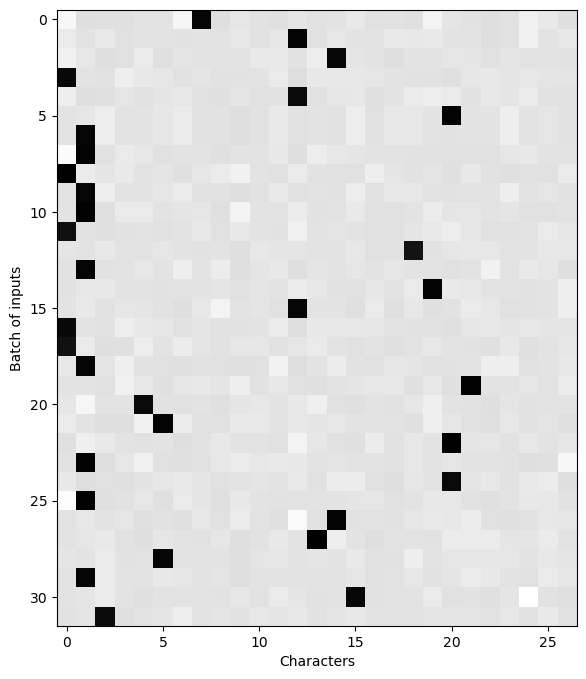

In [659]:
plt.figure(figsize=(8, 8))
plt.xlabel("Characters")
plt.ylabel("Batch of inputs")
plt.imshow(dlogits.detach(), cmap="gray");

In [660]:
dlogits[0].sum()

tensor(-3.7253e-09, grad_fn=<SumBackward0>)

On visualizing the logits, if we see the 0th index at y axis(inputs) 7th index of x axis(27 characters) is negative -0.983 so highlighted in dark black.

The derivatives are the gradients.

What's essentially happending with derivatives is, we're pulling down the wrong probabalites(gray colored) and pulling up the correct probabalities(black colored). Since the sum of gradient across an input is zero, the push and pull are identitical.

The neural network acts like a pulley system to push and pull gradients, which in turn affects the weight and biases. The push and pull is proportional to the corret and incorrect answer (i.e) probabalities in forward pass.

> The amount of push pull in a dimension is proportinal to incorrect probabalities. The incorrectness is calculated by cross_entropy loss.

## Batch Normalization in one go

![Alt bn1](images/bn1.jpg)
![Alt bn2](images/bn2.jpg)
![Alt bn3](images/bn3.jpg)
![Alt bn4](images/bn4.jpg)
![Alt bn5](images/bn5.jpg)

In [661]:
dhprebn = bngain * bnvar_inv/n * (n * dhpreact - dhpreact.sum(0) - n/(n-1) * bnraw * (dhpreact* bnraw).sum(0))

In [662]:
# checking broadcasting
dhpreact.shape, dhpreact.sum(0).shape, bnraw.shape, dhprebn.shape, bngain.shape, bnvar_inv.shape, (dhpreact* bnraw).sum(0).shape

(torch.Size([32, 64]),
 torch.Size([64]),
 torch.Size([32, 64]),
 torch.Size([32, 64]),
 torch.Size([1, 64]),
 torch.Size([1, 64]),
 torch.Size([64]))

In [663]:
cmp("dhprebn", dhprebn, hprebn)

dhprebn         | exact: False | approximate: True  | maxdiff: 4.656612873077393e-10


## Replacing loss.backward() with manual gradients

In [683]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 64 # number of neurons in hidden layer of MLP
torch_seed = 2147483647

g = torch.Generator().manual_seed(torch_seed) # for reproducability
C = torch.randn(vocab_size, n_embed)

# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # just for understanding, useless because of batch normalization
#Layer 2 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# Batch norm paramters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1 

# Instead of zeros, retaining a samll number, 
# because sometimes initializing with all zeros could mask an incorrect implementation of backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

for epoch in range(200000):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb] # embed chars into vectors 
    embcat = emb.view(emb.shape[0], -1) # concatenat the vectors

    # Linear layer 1
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation

    # BatchNorm layer
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    ######

    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    # Linear layer 2
    logits = h @ W2 + b2 # output layer
    # Cross entropy loss (same as F.cross_entropy(logits))
    loss = F.cross_entropy(logits, Yb)

    # PyTorch backward pass
    for p in parameters:
        p.grad = None
    loss.backward() # For compaarison

    #### Manul backprop
    dlogits = F.softmax(logits, 1)
    dlogits[range(n), Yb] -= 1
    dlogits /= n
    # 2nd layer backprop
    dh = dlogits @ W2.T
    dW2 = h.T @ dlogits
    db2 = dlogits.sum(0)
    # batch norm backprop
    dhpreact = (1.0 - h**2) * dh
    dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
    dbnbias = dhpreact.sum(0, keepdim=True)
    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
    dembcat = dhprebn @ W1.T
    dW1 = embcat.T @ dhprebn
    db1 = dhprebn.sum(0)
    # embedding
    demb = dembcat.view(32, 3, 10)
    dC = torch.zeros_like(C)

    for i in range(Xb.shape[0]):
        for j in range(Xb.shape[1]):
            ix = Xb[i, j]
            # index of lookup to demb(gradients)
            dC[ix] += demb[i, j]

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # Update
    lr = 0.1 if epoch < 100000 else 0.01
    # Loss.backward() update for comparison
    for p, grad in zip(parameters, grads):
        p.data += -lr * p.grad
        # p.data += -lr * grad # grads from manual gradient

    if epoch % 10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():4f}")
    lossi.append(loss.log10().item())

    if epoch > 100:
        break

4137
     31/ 200000: 3.345981


In [684]:
# Comparing gradients
for p, g in zip(parameters, grads):
    cmp(str(tuple(p.shape)), g, p)

(27, 10)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(30, 64)        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(64,)           | exact: False | approximate: True  | maxdiff: 6.51925802230835e-09
(64, 27)        | exact: False | approximate: True  | maxdiff: 1.4901161193847656e-08
(27,)           | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
(1, 64)         | exact: False | approximate: True  | maxdiff: 1.862645149230957e-09
(1, 64)         | exact: False | approximate: True  | maxdiff: 5.587935447692871e-09


We've achieved the full gradiens in one-got and it's approximate is true. Let's remove loss.backward()

In [685]:
n_embed = 10 # dimensionality of character embedding vectors
n_hidden = 64 # number of neurons in hidden layer of MLP
torch_seed = 2147483647

g = torch.Generator().manual_seed(torch_seed) # for reproducability
C = torch.randn(vocab_size, n_embed)

# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.1 # just for understanding, useless because of batch normalization
#Layer 2 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.1
b2 = torch.randn(vocab_size, generator=g) * 0.1
# Batch norm paramters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1 

# Instead of zeros, retaining a samll number, 
# because sometimes initializing with all zeros could mask an incorrect implementation of backward pass

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():

    for epoch in range(200000):

        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix]

        emb = C[Xb] # embed chars into vectors 
        embcat = emb.view(emb.shape[0], -1) # concatenat the vectors

        # Linear layer 1
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation

        # BatchNorm layer
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        ######

        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        # Linear layer 2
        logits = h @ W2 + b2 # output layer
        # Cross entropy loss (same as F.cross_entropy(logits))
        loss = F.cross_entropy(logits, Yb)

        # PyTorch backward pass
        for p in parameters:
            p.grad = None

        #### Manul backprop
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # batch norm backprop
        dhpreact = (1.0 - h**2) * dh
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(32, 3, 10)
        dC = torch.zeros_like(C)

        for i in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[i, j]
                # index of lookup to demb(gradients)
                dC[ix] += demb[i, j]

        grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

        # Update
        lr = 0.1 if epoch < 100000 else 0.01
        # Loss.backward() update for comparison
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # loss.backward()
            p.data += -lr * grad # grads from manual gradient

        if epoch % 10000 == 0:
            print(f"{epoch:7d}/{max_steps:7d}: {loss.item():4f}")
        lossi.append(loss.log10().item())

4137
     31/ 200000: 3.314781
     31/ 200000: 2.578549
     31/ 200000: 2.372112
     31/ 200000: 2.332455
     31/ 200000: 2.070600
     31/ 200000: 2.110276
     31/ 200000: 2.200143
     31/ 200000: 2.348270
     31/ 200000: 2.454972
     31/ 200000: 2.300684
     31/ 200000: 2.247980
     31/ 200000: 2.303355
     31/ 200000: 2.189549
     31/ 200000: 1.841415
     31/ 200000: 2.478203
     31/ 200000: 1.931649
     31/ 200000: 2.374298
     31/ 200000: 2.157724
     31/ 200000: 2.241688
     31/ 200000: 2.166559


Dumb mistake in not replacing i with epoch. So all the epochs come as 31.

In [686]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmahela.
jheri.
kimri.
reh.
cassanden.
jazonte.
den.
rha.
kaqui.
ner.
kiarceriivin.
leig.
dham.
join.
quint.
suline.
liveni.
waatho.
dearyxia.
kaellius.


So I've tried to learn differentiation and how the gradients are flowing through in backwad pass at a very granular level.
And achieved backward propogation without PyTorch's autograd engine.
This brings us to closure of this notebook.